<h1> Homework 09


In [1]:
#imports
import numpy as np
import matplotlib.pyplot as plt     
import scipy.stats as stats
import scipy.special as special
import seaborn as sns               
import pandas as pd

from matplotlib.colors import ListedColormap
#using this to create a discrete color map :^)

%matplotlib inline
#watermark
import watermark 
%load_ext watermark 
%watermark -v -m -p numpy,matplotlib,seaborn,pandas,jupyterlab

Python implementation: CPython
Python version       : 3.12.5
IPython version      : 8.27.0

numpy     : 2.1.1
matplotlib: 3.9.2
seaborn   : 0.13.2
pandas    : 2.2.2
jupyterlab: 4.2.5

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit



<h1> 1. reproduce Wiggins' K-means result
<h4> Write a standard K-means clustering procedure. Use it to cluster Wiggins' data into K=5 clusters. Plot the results, similar to his figure. You should be able to reproduce a similarly bad result.

<h4> You'll want to run the K-means algorithm multiple times and choose the best. What is a good statistic for choosing the "best" solution for K-means? You should be able to reproduce Wiggins' "tot_sqdist" measure.

<h4> Why is K-means clustering producing this result, when there are clearly five distinct clusters in the data?

In [2]:
#Load data table:
file_name = 'homework_9/w09-data.tbl'

file = open(file_name, 'r')
lines = file.readlines()

data = np.zeros((len(lines)-1, 4))

for i, line in enumerate(lines[1:1001]): #do not consider the header
    parts = line.strip().split() #split by space delimiter
    #extract cell ID, true type, defA and kilA gene expression
    cellnum = float(parts[0])
    cell_type = float(parts[1])
    defA = float(parts[2])
    kilA = float(parts[3]) 
    data[i, :] = [cellnum, cell_type, defA, kilA]

unique_cell_types = np.unique(data[:, 1])  # Get unique cell types
avg_expression = []
for cell_type in unique_cell_types:
    #select rows corresponding to current cell type
    cell_data = data[data[:, 1] == cell_type]
    
    #calculate mean for defA and kilA expressions
    avg_defA = np.mean(cell_data[:, 2])
    avg_kilA = np.mean(cell_data[:, 3])
    
    #append results as (cell_type, avg_defA, avg_kilA)
    avg_expression.append([avg_defA, avg_kilA])

#convert to structured output for display
avg_expression = np.array(avg_expression)

<h4> Plotting the true data in order to compare my clustering methods

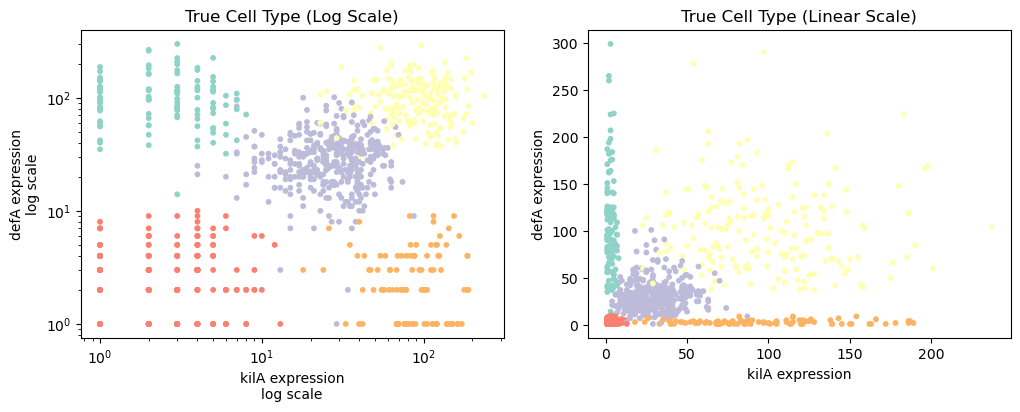

In [3]:
#Plot the true data
k = 5
base_cmap = plt.get_cmap('Set3')
colors = base_cmap(np.linspace(0, k/12, k))  #Sample k colors across the entire colormap
cmap = ListedColormap(colors)

#Plotting two plots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# catter plot with log scale
scatter_log = axes[0].scatter(data[:, 2], data[:, 3], s=10, c=data[:, 1], cmap=cmap)
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('kilA expression\nlog scale')
axes[0].set_ylabel('defA expression\nlog scale')
axes[0].set_title("True Cell Type (Log Scale)")

#Scatter plot without log scale
scatter = axes[1].scatter(data[:, 2], data[:, 3], s=10, c=data[:, 1], cmap=cmap)
axes[1].set_xlabel('kilA expression')
axes[1].set_ylabel('defA expression')
axes[1].set_title("True Cell Type (Linear Scale)")

# Display the plots
plt.show()

<h4> Analyzing fraction of cells in each cluster

In [4]:
def print_fraction(cluster_assignments):
    """
    input: cluster_assignments index represents each cell and value represents the cluster to which it's assigned
    output: prints fraction of points assigned to each of the clusters
    """
    k = int(np.max(cluster_assignments) - np.min(cluster_assignments) + 1)
    n = len(cluster_assignments)
    print("cluster\tfraction")
    for i in range(k):
        fraction = np.sum(cluster_assignments == i) / n  #calculate the fraction of points in each cluster
        print(f"{i}\t{np.round(fraction, 3)}")

#The second column of the dataset is the true cell assignment
print_fraction(data[:, 1])

cluster	fraction
0	0.114
1	0.191
2	0.388
3	0.208
4	0.099


<h4> There is not an even distribution of cells per type of cell being analyzed. ~40% of all cells are of type 2, while ~10% are of both type 0 and 4. This uneven fraction in the dataset will cause problems for k-means clustering. One of the implicit assumptions of k-means clustering is that each component has an equal expected number of data points.

In [5]:
def kmeans_clustering(data, k, max_iter=100, tolerance=1e-5):
    """
    inputs:
    k (int): The number of clusters
    data (4*n array where n is # of cells): 
        contains cell ID in first column, true type in the second column, and expression of kilA and defA in the 3rd and 4th column
    max_iter (int): Maximum value
    tolerance: for use in calculating whether we have converged on the centroids

    returns: 
    cluster_assignments (1d array): each value represents the cluster to which the index cell is assigned to
    centroids (2d array): representing x and y coordinates for each centroid
    total_distance (float): total square distance calculation
    """
    data_exp = data[:, 2:] #use only the expression data
    
    n = data_exp.shape[0] #number of points
    
    #INITIALIZE RANDOM CENTROIDS
    #first centroids are assigned to random points
    indices = np.random.choice(data_exp.shape[0], k, replace=False)
    centroids = data_exp[indices, :]

    #ASSIGNMENT
    cluster_assignments = np.empty((n))
    distances = np.empty((n))
    cluster_counts = np.zeros((k))

    iteration = 0
    convergence = False

    #continue reassigning until points converge or we reach maximum iterations
    while not convergence and iteration < max_iter:
        prev_centroids = centroids
        
        for i in range(n): #go through all points and assign to closest centroid, store distance
            point = data_exp[i, :] #
            dist_to_centroids = [np.linalg.norm(point - centroid) for centroid in centroids] #calculate distance to all centroids
            closest_centroid = np.argmin(dist_to_centroids) #assign to closest centroid
            shortest_dist = np.min(dist_to_centroids) #keep shortest distance in mind for distance calculation
            cluster_assignments[i] = closest_centroid
            distances[i] = shortest_dist
    
            #Increment number of points in each cluster
            cluster_counts[closest_centroid] += 1
    
        #If cluster is empty
        #Reassign the data point farthest from any current center to the specified empty cluster.
        for i in range(k):
            if cluster_counts[i] == 0:
                #Identify the index of the point farthest from its assigned center
                farthest_point_idx = np.argmax(distances)
                
                #Assign this point to the empty cluster and reset its distance to 0
                cluster_assignments[farthest_point_idx] = i
                distances[farthest_point_idx] = 0
    
        #Calculate the updated centroids by averaging points in each cluster
        centroids = np.array([data_exp[cluster_assignments == x].mean(axis=0) for x in range(k)])

        #increment iteration counter
        iteration += 1

        convergence = np.allclose(centroids, prev_centroids, atol=tolerance)
    total_distance = sum(distances**2)
    
    return cluster_assignments, centroids, total_distance

In [6]:
def plot_clusters(data, cluster_assignments, centroids, k, total_distance, repeats, title, log_scale = True):
    base_cmap = plt.get_cmap('Set3')
    colors = base_cmap(np.linspace(0, k/12, k))  #Sample k colors across the entire colormap
    cmap = ListedColormap(colors)

    #plot the points
    plt.figure(figsize=(6, 4))
    scatter = plt.scatter(data[:, 2], data[:, 3], s = 10, c=cluster_assignments, cmap = cmap)
    
    #mark centroids with a star symbol
    plt.scatter(centroids[:, 0], centroids[:, 1], color = "black", marker='*', s=100, label='Centroids')

    plt.xlabel('kilA expression')
    plt.ylabel('defA expression')
    # Log scale for both axes
    if log_scale == True:
        plt.xscale('log')
        plt.yscale('log')
    
        # Add legend and labels
        #plt.colorbar(scatter, label='Cluster Assignment')
        plt.xlabel('kilA expression\nlog scale')
        plt.ylabel('defA expression\nlog scale')

    #make a title string
    if total_distance > 0:
        title = f"{title}\n\nTotal Square Distance = {np.round(total_distance)}\nRepeats = {repeats}"
    else: 
        title = f"{title}\n\nRepeats = {repeats}"
    plt.title(title)
    plt.legend(loc = 'upper left')
    plt.show()

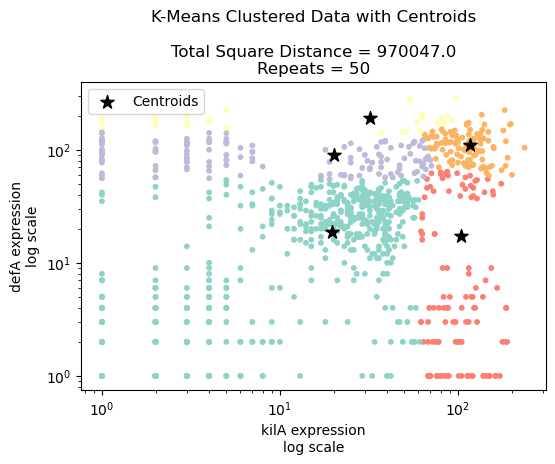

In [16]:
def choose_best_kmeans(data, k, repeats):
    """
    repeats (int): number of times to rerun kmeans_clustering
    stores best results (centroids and clusters) based on smallest total_distance result 
    returns: cluster_assignmnets, centroids, and total_distance
    """
    best_centroids = None
    best_cluster_assignments = None
    smallest_total_distance = np.inf
    
    for i in range(repeats):
        cluster_assignments, centroids, total_distance = kmeans_clustering(data, k)
        if total_distance < smallest_total_distance:
            smallest_total_distance = total_distance
            best_centroids = centroids
            best_cluster_assignments = cluster_assignments
    return best_cluster_assignments, best_centroids, smallest_total_distance


repeats = 50
k = 5

cluster_assignments, centroids, total_distance = choose_best_kmeans(data, k, repeats)
plot_clusters(data, cluster_assignments, centroids, k, total_distance, repeats = repeats, title = "K-Means Clustered Data with Centroids")

<h4> Above, I have reproduced Moriarty's poor result and his total square distance calculation.

<h4> From lecture 9, k-means is extremely prone to spurious local optima. As seen above, you can have perfectly obvious clusters yet end up with multiple centroids on one cluster and none on another that nonetheless minimize distance. In this scenario, the top right regions which has two types of cells has many of the centroids and is distributed amongst all the clusters. Some of the centroids are located in space with no points nearby. This is not a good result. 

<h4> One reason that this occurs is that the true clusters don't have even distribution of points (there's a lot of points in the top right true clusters and relatively few in the other clusters, which skews the centroids). K means assumes that each cluster has an equal expected number of data points, which is violated by our dataset.

<h4> The data in each cluster is not actually distributed evenly (through negative binomial). The clusters aren't perfect circles with more data point density in the middle. The data in each cluster is not actually distributed evenly. The clusters aren't perfect circles with more data point density in the middle. Another important assumption of k means is that the data is drawn from from a mixture Gaussian distribution composed of spherical Gaussians and that each component has an identical spherical Gaussian variance, visualized through the 'width' of each component. Unfortunately, the true clusters in this dataset do not all look like this. Some clusters are more spread out than others and do not follow a 'normal' distribution.

<h4> Another reason is that the data visualization that Moriarty uses is not consistent with the data input into the k means clustering algorithm. The k means clustering data is run on the absolute expression values of kilA and defA for each cell, whereas the data is plotted on log-scaled axes. However, the distance of points in log scale is different than in absolute space, which is another reason that the output clusters appear so strange. By visualizing the clusters on a non-log scale, we can see that the clusters are imperfect but 'make more sense' and better resemble the true clusters when the data is represented on a linear scale. This issue is addressed in part three.

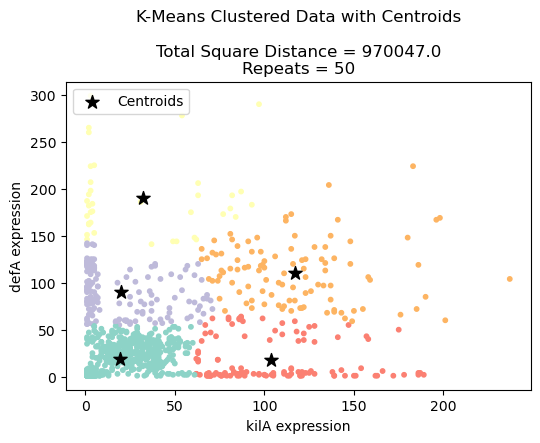

In [17]:
plot_clusters(data, cluster_assignments, centroids, k, total_distance, repeats = repeats, title = "K-Means Clustered Data with Centroids", log_scale = False)

In [18]:
def print_table(cluster_assignments, centroids):
    k = centroids.shape[0]
    n = len(cluster_assignments)
    print("cluster\tfraction  mean counts defA\tkilA")
    for i in range(k):
        fraction = np.sum(cluster_assignments == i)/n #how many of the cluster_assignmments 
        defA = centroids[i, 1]
        kilA = centroids[i, 0]
        print(f"{i}\t{np.round(fraction, 3)}\t\t      {np.round(defA, 3)}\t{np.round(kilA, 3)}")

print("K means result")
print_table(cluster_assignments, centroids)
print("\n\nTrue values")
print_table(data[:, 1], avg_expression)

K means result
cluster	fraction  mean counts defA	kilA
0	0.599		      18.606	19.616
1	0.037		      190.054	31.973
2	0.143		      89.692	20.105
3	0.118		      17.331	103.831
4	0.103		      110.835	116.903


True values
cluster	fraction  mean counts defA	kilA
0	0.114		      106.614	2.982
1	0.191		      101.963	97.016
2	0.388		      30.716	29.314
3	0.208		      3.048	3.173
4	0.099		      2.859	92.899


<h4> These are the cluster fractions (number of data points assigned to each cluster) and the aveage defA and kilA expression values for each cell type predicted by the Moriarty's poor k means results. They are very different from the true result.

<h1> 2. mixture negative binomial fitting
<h4> 
Now you're going to use what you've learned about mixture models, and about the negative binomial distribution for RNA-seq data.

<h4>Write an expectation maximization algorithm to fit a mixture negative binomial distribution to Wiggins' data, for Q=5 components in the mixture.

<h4>Assume there is a common dispersion $\phi = 0.2$. This means that all you need to re-estimate in the EM algorithm are the means $\mu$ and mixture coefficients $\pi$ for each mixture component.

<h4>Like K-means, EM is a local optimizer, so you will want to run your EM algorithm from multiple initial conditions, and take the best one. What is an appropriate statistic for choosing the "best" fit?

<h4>What are the estimated mean expression levels of defA and kilA in the five cell types, and the relative proportions of each cell type in the 1000 cells?

<h4>Visualize your result in a plot similar to Wiggins'.

In [10]:
def expectation_maximization(data, k, repeats):
    """
    to make my EM function, I combined components from Liana's section code
    and changed the probability calculation to account for the negative binomial distribution we expect
    """
    Q = k
    
    data_exp = data[:, 2:]
    n = data_exp.shape[0]
    
    phi = 0.2 #given
    
    #INITIALIZE
    #calculate centroids by randomly assigning points
    indices = np.random.choice(data_exp.shape[0], k, replace=False)
    centroids = data_exp[indices, :]

    mixture_coefficients = np.ones(Q) / Q  #Start with equal mixture weights for each component
    
    for i in range(repeats):
        #EXPECTATION
        log_posterior_probability = np.zeros((n, Q))
        for p in range(n): #through all points
            point = data_exp[p, :]
            #print(point)
            for q in range(Q): #through all centroids
                centroid = centroids[q, :]
                #obtain posterior probability using mixture coefficients and assumption that it's a negative binomial distribution
                #negative binomial parameters determined by phi value (dispersion)
                log_posterior_probability[p, q] = np.log(mixture_coefficients[q]) + np.sum(stats.nbinom.logpmf(point, 1/phi, 1/(1 + centroid * phi)))
            #Normalize to obtain the posterior probability that each data point comes from each component
            total_log_prob = special.logsumexp(log_posterior_probability[p, :])
            log_posterior_probability[p, :] -= total_log_prob
        
        #Assign clusters based on max posterior probability
        cluster_assignments = np.argmax(log_posterior_probability, axis=1)
        
        #maximization
        #recalculate centroids based on weighted average by probability
        for q in range(Q):
            assigned_points = data_exp[cluster_assignments == q]
            assigned_log_probs = log_posterior_probability[cluster_assignments == q, q]
        
            #Numerator in log space: logsumexp of weighted data points
            weighted_log_sum = special.logsumexp(assigned_log_probs[:, np.newaxis] + np.log(assigned_points), axis=0)
        
            #Denominator in log spac: logsumexp of assigned log probabilities
            total_log_weight = special.logsumexp(assigned_log_probs)
        
            #Update centroid for cluster q (weighted average in log space)
            centroids[q, :] = np.exp(weighted_log_sum - total_log_weight)
            mixture_coefficients[q] = np.mean(np.exp(log_posterior_probability[:, q]))

    #total distance calculation
    total_distance = 0
    for p in range(n):
        point = data_exp[p, :]
        assigned_centroid = centroids[cluster_assignments[p], :]
        squared_distance = np.sum((point - assigned_centroid) ** 2)
        total_distance += squared_distance    

    return cluster_assignments, centroids, total_distance

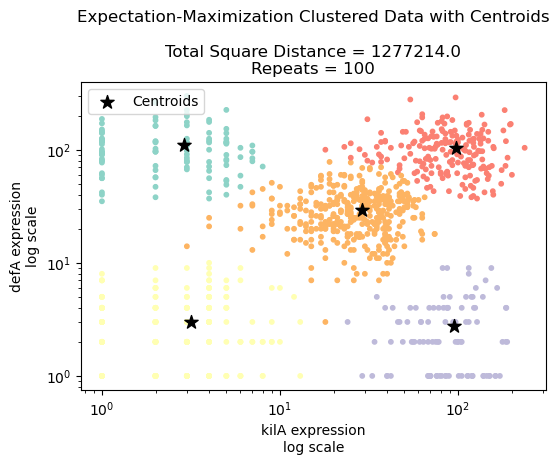

In [11]:
repeats = 100

cluster_assignments, centroids, total_distance = expectation_maximization(data, k, repeats)
plot_clusters(data, cluster_assignments, centroids, k, total_distance, repeats = repeats, 
              title = "Expectation-Maximization Clustered Data with Centroids")

<h4> This is a much better approximation of Wiggins true type plot that is possible with a local optimization method like expectation-maximization. There are some datapoints on the edges of clusters that really belong to another cluster and wrongly clustered in another group. These edge cases are hard to resolve because expectation-maximization prioritizes local optimization. 
    
<h4> Outliers in the true data (for example there are some points located in the middle of the center cluster that actually belong to the top right cluster) will never achieve correct assignment, but that does not dismiss the fact that this is still a much better clustering.

<h4> It's interesting to note that the total square distance calculation is actually higher with this method. This again has to do with the inconsistency with how the data is visualized via log scale and the calculation itself of the EM algorithm being with the absolute data values. This is resolved in the next step. The calculation is not on the same scale as the graph itself which is why it is higher than the k means result despite obviously achieving better clusters.

In [12]:
print("Expectationn maximization results")
print_table(cluster_assignments, centroids)
print("\n\nTrue values")
print_table(data[:, 1], avg_expression)

Expectationn maximization results
cluster	fraction  mean counts defA	kilA
0	0.112		      109.921	2.904
1	0.209		      3.027	3.151
2	0.099		      2.76	94.551
3	0.195		      103.864	97.359
4	0.385		      29.077	28.757


True values
cluster	fraction  mean counts defA	kilA
0	0.114		      106.614	2.982
1	0.191		      101.963	97.016
2	0.388		      30.716	29.314
3	0.208		      3.048	3.173
4	0.099		      2.859	92.899


<h4> The table visualizes the fraction of cells belonging to each type and the mean expression of defA and kilA genes for each type of cell. This is a much more accurate result than was achieved using k-means! We can confirm what was previously observed visually that there is uneven distribution of points among the cluster, with one cluster having ~40% of the data and two others having ~10%. Ideally each cluster would have ~20% of all points.
    
<h4> Importantly, the number assigned to each cell type might not match the cluster number assigned, a product of randomly selecting initial centroids. For example, the cluster that has true identity of type 1 may be associated with centroid number 3.

<h1> 3. find a simple fix for K-means
<h4> Suggest a simple fix for the problem in applying a standard K-means clustering algorithm to Wiggins' single cell RNA-seq data. Implement the fix, re-run the K-means clustering, pick a "best" solution; report and visualize it.



<h4> To improve the performance of the K-means algorithm on this dataset, I propose applying a log transformation to all expression values and plotting them on a regular scale. Wiggins' original plot used raw, non-log-transformed data on a log scale, which resulted in dense patches (e.g., in the top right corner) and more sparse areas (e.g., in the bottom right). This uneven distribution does not align well with the Gaussian assumptions underlying K-means, leading to clustering artifacts (I elaborated on this in part 1)

A log transformation would compress higher expression values and expand lower ones, helping to approximate a more Gaussian-like, or log-normal, distribution across the dataset. This adjustment should create a more balanced spread of data points, allowing K-means to identify clusters more effectively. Additionally, it would reduce the skewness in the data, improving the even distribution among clusters that K-means requires for optimal performance.

In [13]:
log_data = data.copy()  #copy the original data to preserve it
log_data[:, 2:] = np.where(data[:, 2:] > 0, np.log(data[:, 2:]), 0)  #Log-transform only positive values, set zeros to zero

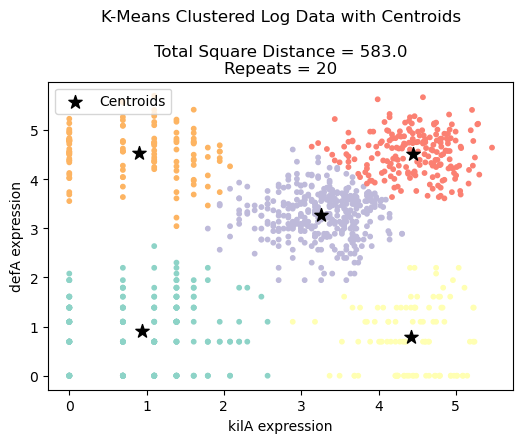

In [14]:
repeats = 20
k = 5

cluster_assignments, centroids, total_distance = choose_best_kmeans(log_data, k, repeats)
plot_clusters(log_data, cluster_assignments, centroids, k, total_distance, repeats = repeats, 
              title = "K-Means Clustered Log Data with Centroids", log_scale = False)

In [15]:
print("Expectation maximization results")
print_table(cluster_assignments, np.exp(centroids))
print("\n\nTrue values")
print_table(data[:, 1], avg_expression)

Expectation maximization results
cluster	fraction  mean counts defA	kilA
0	0.21		      2.503	2.572
1	0.1		      2.221	83.486
2	0.372		      26.5	26.008
3	0.202		      92.011	85.357
4	0.116		      93.96	2.46


True values
cluster	fraction  mean counts defA	kilA
0	0.114		      106.614	2.982
1	0.191		      101.963	97.016
2	0.388		      30.716	29.314
3	0.208		      3.048	3.173
4	0.099		      2.859	92.899


<h4> While the ordering of these is different because the cluster number assignment is arbitrary, the right fractions are achieved as well as good approximations for the true expression of defA and kilA in each cell type. Woohoo!